In [1]:
import os
import logging
from pathlib import Path
import datetime

import numpy as np
import math
import random
import pandas as pd

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

import torchmetrics

import cv2

import onnx
import onnxruntime as ort

# Logger

In [2]:
log_path = 'inference_DFire/'

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny. Neural Compression Quantization INT8 Model. ONNX Inference. DFire Dataset.\n')

# Config

In [3]:
CLASSES = ["smoke", "fire"]
N_CLASSES = len(CLASSES)

IMG_DIM = {'W':224, 'H':224} # (W, H)
IMG_H = IMG_DIM['H']
IMG_W = IMG_DIM['W']

# DFire Dataset

In [4]:
class DFireDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - num_classes:      number of classes
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded: [smoke, fire]
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, num_classes,
                 ds_len,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.num_classes = num_classes
        self.ds_len = ds_len
        self.transform = transform
        self.target_transform = target_transform
        
        self.except_transform = A.Compose([
                                    A.Resize(self.img_h, self.img_w, p=1),
                                    ToTensorV2(p=1),
                                    ]
                                )

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )
    
        if ds_len is not None:
            random.seed(123)
            random.shuffle(self.labels_list)
            self.images_path, self.labels = self.__build_ds__(self.labels_list[:self.ds_len])
            self.num_samples = len(self.labels_list[:self.ds_len])
        else:
            self.images_path, self.labels = self.__build_ds__(self.labels_list)
            self.num_samples = len(self.labels_list)

    def __len__(self):
        return self.num_samples   

    def __build_ds__(self, labels_list):
        labels = []
        images = []
        wrong_imgs = 0
        empty = 0
        only_smoke = 0
        only_fire = 0
        smoke_fire = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_array = np.zeros((self.num_classes))
            
                with open(label) as f:
                    lines = f.readlines()
                       
                    for line in lines:
                        class_id, _, _, _, _ = line.strip().split()
                        class_id = int(class_id)
                        if np.array_equal(label_array, np.array([1, 1])):
                            break
                        else:
                            label_array[class_id] = 1.

                    if np.array_equal(label_array, np.array([1, 1])):
                        smoke_fire += 1
                    elif np.array_equal(label_array, np.array([0, 1])):
                        only_fire += 1
                    elif np.array_equal(label_array, np.array([1, 0])):
                        only_smoke += 1
                    elif np.array_equal(label_array, np.array([0, 0])):
                        empty += 1
                    else:
                        print("Wrong label in DFire dataset")
                        logger.info("Wrong label in DFire dataset")
                        
                    labels.append(label_array)
                    images.append(image_path)
        
        print(f'DFire Removed wrong images: {wrong_imgs}')
        logger.info(f'DFire Removed wrong images: {wrong_imgs}')
        print(f'DFire empty images: {empty}')
        logger.info(f'DFire empty images: {empty}')
        print(f'DFire only smoke images: {only_smoke}')
        logger.info(f'DFire only smoke images: {only_smoke}')
        print(f'DFire only fire images: {only_fire}')
        logger.info(f'DFire only fire images: {only_fire}')
        print(f'DFire smoke and fire images: {smoke_fire}')
        logger.info(f'DFire smoke and fire images: {smoke_fire}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        images_array = np.array(images)
        
        return images_array, labels_tensor

    def __getitem__(self, index):

        # Image processing
        img_file = self.images_path[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   

        # Labels processing
        label = self.labels[index]
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img)
                img = aug['image'] / 255.0
            except:
                #print(f'Error trying to augment image {img_file}')
                aug = self.except_transform(image=img)
                img = aug['image'] / 255.0
        
        return img, label

# Images and Folders

In [5]:
ds_dir = '../../../datasets/ds2fire/dfire_yolo/'

#val_dir = ds_dir + 'test/'

val_dir = ds_dir + 'test/'
val_imgs = val_dir + 'images/'
val_labels = val_dir + 'labels/'

print(f'Val dir: {os.listdir(val_dir)}')

Val dir: ['labels', '.ipynb_checkpoints', 'images']


# Hyperparameters

In [6]:
''' ============================
    Hyperparameters and More
============================ '''

MODEL = "BED"

#DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64 
NUM_WORKERS = 8
PIN_MEMORY = True
LOAD_MODEL = True

VAL_IMG_DIR = val_imgs
VAL_LABEL_DIR = val_labels

DS_LEN = None

# Dataset Setup

In [7]:
# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(IMG_H, IMG_W, p=1),
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
val_dataset = DFireDataset(img_h = IMG_H,
                           img_w = IMG_W,
                           img_dir = VAL_IMG_DIR,
                           label_dir = VAL_LABEL_DIR,
                           num_classes = N_CLASSES,
                           ds_len = DS_LEN,
                           transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'Test dataset len: {len(val_dataset)}\n')


# LOADERS
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        pin_memory=PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Model Load

In [8]:
onnx_model = onnx.load("int8-model.onnx")

In [9]:
onnx.checker.check_model(onnx_model)

# Inference 1 Picture

In [10]:
ort_sess = ort.InferenceSession('int8-model.onnx')

In [11]:
for img, label in val_loader:
    global pic
    print(img.shape)
    pic = img
    break

torch.Size([64, 3, 224, 224])


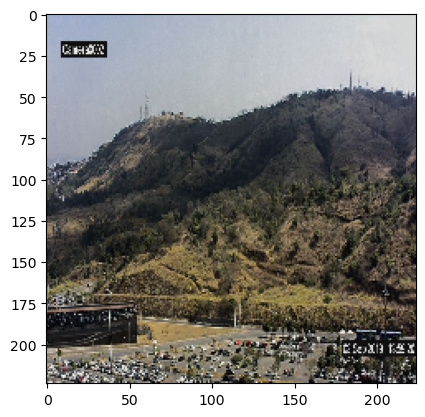

In [12]:
plt.imshow(pic[3].squeeze().permute(1, 2, 0))

In [13]:
outputs = ort_sess.run(None, {'input': pic[3:4].numpy()})

In [14]:
print(outputs)

[array([[-0.55756354, -8.363453  ]], dtype=float32)]


# All Metrics Evaluation

In [15]:
precision_metric = torchmetrics.classification.MultilabelPrecision(num_labels = N_CLASSES, 
                                                                   threshold = 0.5, 
                                                                   average = None).to('cpu')
recall_metric = torchmetrics.classification.MultilabelRecall(num_labels = N_CLASSES, 
                                                             threshold = 0.5, 
                                                             average = None).to('cpu')
accuracy_metric = torchmetrics.classification.MultilabelAccuracy(num_labels = N_CLASSES, 
                                                                 threshold = 0.5, 
                                                                 average = None).to('cpu')
f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels = N_CLASSES, 
                                                          threshold = 0.5, 
                                                          average = None).to('cpu')

In [16]:
def eval_all_metrics():
               
    for image, label in val_loader:
        output = ort_sess.run(None, {'input': image.numpy()})
        output = torch.tensor(np.array(output[0]))
        precision_metric.update(output, label)
        recall_metric.update(output, label)
        accuracy_metric.update(output, label)
        f1_metric.update(output, label)

    pre_res = precision_metric.compute()
    rec_res = recall_metric.compute()
    acc_res = accuracy_metric.compute()
    f1_res = f1_metric.compute()

    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
        
    return {
        'Accuracy': acc_res,
        'Precision': pre_res,
        'Recall': rec_res,
        'F1-score': f1_res
    }   

In [17]:
all_metrics = eval_all_metrics()

In [18]:
print(all_metrics)
for k, v in all_metrics.items():
    logger.info(k)
    logger.info(f'\tSmoke: {100*v[0]:.2f} %')
    logger.info(f'\tFire: {100*v[1]:.2f} %')

{'Accuracy': tensor([0.9065, 0.9536]), 'Precision': tensor([0.9223, 0.9505]), 'Recall': tensor([0.8798, 0.8658]), 'F1-score': tensor([0.9005, 0.9062])}


In [19]:
metrics_data = np.zeros((2, 4))
for i, (k, v) in enumerate(all_metrics.items()):
    metrics_data[0, i] = np.round(100*v[0].item(), decimals=2)
    metrics_data[1, i] = np.round(100*v[1].item(), decimals=2)
metrics_data

array([[90.65, 92.23, 87.98, 90.05],
       [95.36, 95.05, 86.58, 90.62]])

In [20]:
index = ['Smoke', 'Fire']
cols = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
df = pd.DataFrame(metrics_data, index = index, columns = cols)
df

,Accuracy,Precision,Recall,F1-Score
Smoke,90.65,92.23,87.98,90.05
Fire,95.36,95.05,86.58,90.62
